In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [3]:
train = pd.read_csv('../data/sentiment_analysis.csv')

In [4]:
print('The train dataset contains {} rows and {} columns.'.format(train.shape[0], train.shape[1]))

The train dataset contains 499 rows and 7 columns.


In [5]:
print(train.columns)

Index(['Year', 'Month', 'Day', 'Time of Tweet', 'text', 'sentiment',
       'Platform'],
      dtype='object')


In [6]:
train.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [7]:
train.tail()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
494,2015,10,18,night,"According to , a quarter of families under six...",negative,Twitter
495,2021,2,25,morning,the plan to not spend money is not going well,negative,Instagram
496,2022,5,30,noon,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,2018,8,10,night,congratulations ! you guys finish a month ear...,positive,Twitter
498,2019,3,25,morning,"actually, I wish I was back in Tahoe. I miss...",negative,Instagram


In [8]:
train.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year,499.0,NaN,NaN,NaN,2020.39479,2.830991,2010.0,2019.0,2021.0,2023.0,2023.0
Month,499.0,NaN,NaN,NaN,6.084168,3.652711,1.0,2.0,6.0,9.0,12.0
Day,499.0,NaN,NaN,NaN,15.693387,8.804673,1.0,8.0,15.0,22.0,31.0
Time of Tweet,499,3,morning,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,499,394,Grabbing coffee from then making mom breakfast,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sentiment,499,3,neutral,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform,499,5,Instagram,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train.describe()

,Year,Month,Day
count,499.000000,499.000000,499.000000
mean,2020.394790,6.084168,15.693387
std,2.830991,3.652711,8.804673
min,2010.000000,1.000000,1.000000
25%,2019.000000,2.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,31.000000


In [10]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB
None


In [11]:
print(train.nunique())

Year              14
Month             12
Day               31
Time of Tweet      3
text             394
sentiment          3
Platform           5
dtype: int64


In [12]:
print(train.isnull().sum())

Year             0
Month            0
Day              0
Time of Tweet    0
text             0
sentiment        0
Platform         0
dtype: int64


In [13]:
print(train['sentiment'].nunique())

3


In [14]:
print(train.sentiment.unique())

['positive' 'negative' 'neutral']


In [14]:
train['sentiment'].mode()

0    neutral
Name: sentiment, dtype: object

In [15]:
print(train['sentiment'].value_counts())

neutral     199
positive    166
negative    134
Name: sentiment, dtype: int64


In [4]:
neutral_response_percentage = train['sentiment'].value_counts()['neutral']/train['sentiment'].count()
positive_response_percentage = train['sentiment'].value_counts()['positive']/train['sentiment'].count()
negative_response_percentage = train['sentiment'].value_counts()['negative']/train['sentiment'].count()

print('Neutral: ', neutral_response_percentage * 100,'%\n','Positive: ', positive_response_percentage * 100,'%\n', 'Negative: ', negative_response_percentage*100,'%')

Neutral:  39.879759519038075 %
 Positive:  33.26653306613226 %
 Negative:  26.853707414829657 %


In [14]:
train_positive = train.loc[train['sentiment'] == 'positive']
train_positive.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
6,2017,12,28,morning,2 am feedings for the baby are fun when he is ...,positive,Facebook
9,2018,5,28,morning,Today first time I arrive in the boat. Its ama...,positive,Facebook
11,2016,4,10,night,I really really like the song Cardigan by Tayl...,positive,Twitter


In [18]:
train_positive.describe()

,Year,Month,Day
count,166.000000,166.000000,166.000000
mean,2020.530120,5.578313,15.156627
std,3.044468,3.740428,8.522316
min,2011.000000,1.000000,1.000000
25%,2019.000000,2.000000,8.000000
50%,2022.000000,5.000000,15.000000
75%,2023.000000,9.000000,20.000000
max,2023.000000,12.000000,30.000000


In [19]:
train_negative = train.loc[train['sentiment'] == 'negative']
train_negative.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram
12,2016,5,15,morning,My Sharpie is running DANGERously low on ink,negative,Facebook
13,2016,11,15,noon,i want to go to music tonight but i lost my vo...,negative,Instagram


In [20]:
train_negative.describe()

,Year,Month,Day
count,134.000000,134.000000,134.000000
mean,2020.134328,6.052239,16.119403
std,2.719440,3.596818,8.569964
min,2013.000000,1.000000,1.000000
25%,2018.000000,3.000000,8.000000
50%,2021.000000,6.000000,15.500000
75%,2023.000000,9.000000,24.000000
max,2023.000000,12.000000,30.000000


In [21]:
train_neutral = train.loc[train['sentiment'] == 'neutral']
train_neutral.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
5,2016,11,22,night,"Its night 2 am, feeling neutral",neutral,Facebook
7,2017,12,28,noon,Soooo high,neutral,Instagram
8,2019,10,28,night,Both of you,neutral,Twitter
10,2021,11,7,noon,Love is something like E=MC^2 rules,neutral,Instagram
14,2016,11,15,night,Always somewhere I miss you where I have been,neutral,Twitter


In [22]:
train_neutral.describe()

,Year,Month,Day
count,199.000000,199.000000,199.000000
mean,2020.457286,6.527638,15.854271
std,2.720468,3.577143,9.204954
min,2010.000000,1.000000,1.000000
25%,2019.000000,3.000000,8.000000
50%,2021.000000,7.000000,15.000000
75%,2023.000000,9.500000,23.500000
max,2023.000000,12.000000,31.000000


<Axes: xlabel='sentiment', ylabel='count'>

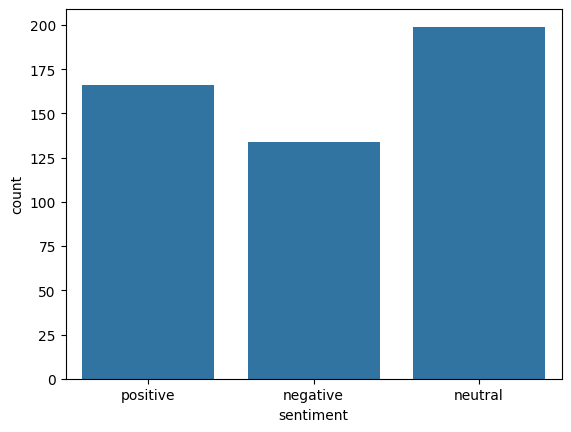

In [15]:
sns.countplot(x = train["sentiment"])

In [16]:
train.drop(columns=['Year', 'Month', 'Day', 'Time of Tweet', 'Platform'], inplace=True)

In [17]:
train.head()

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative


In [18]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text).replace('  ', ' ')

In [19]:
train['url_removed'] = train['text'].apply(lambda x: remove_urls(x))
train[['text', 'url_removed']].tail()

,text,url_removed
494,"According to , a quarter of families under six...","According to , a quarter of families under six..."
495,the plan to not spend money is not going well,the plan to not spend money is not going well
496,uploading all my bamboozle pictures of facebook,uploading all my bamboozle pictures of facebook
497,congratulations ! you guys finish a month ear...,congratulations ! you guys finish a month ear...
498,"actually, I wish I was back in Tahoe. I miss...","actually, I wish I was back in Tahoe. I miss ..."


In [20]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', punctuation))
    return text

In [23]:
train['punctuation_removal'] = train['url_removed'].apply(lambda x: remove_punctuation(x))
train[['text', 'punctuation_removal']].tail()

,text,punctuation_removal
494,"According to , a quarter of families under six...",According to a quarter of families under six ...
495,the plan to not spend money is not going well,the plan to not spend money is not going well
496,uploading all my bamboozle pictures of facebook,uploading all my bamboozle pictures of facebook
497,congratulations ! you guys finish a month ear...,congratulations you guys finish a month earl...
498,"actually, I wish I was back in Tahoe. I miss...",actually I wish I was back in Tahoe I miss it...


In [24]:
def text_clean(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[""''_]', '', text)
    text = re.sub('\n', '', text)
    return text

In [25]:
def decontract_text(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"\'t've", " not have", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'clock", "f the clock", text)
    text = re.sub(r"\'cause", " because", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\’didn't", " did not", text)

    return text

In [26]:
train['cleaned_description'] = train['punctuation_removal'].apply(lambda x: decontract_text(x))
train['cleaned_description'] = train['cleaned_description'].apply(lambda x: text_clean(x))

In [27]:
print('Original Description:\n', train['text'][20])
print('Cleaned Description:\n', train['cleaned_description'][20])
# This column will be used while training our model.

Original Description:
  oh Maya, I`m so sorry!!  I hope you find her soon!! 
Cleaned Description:
  oh Maya Im so sorry I hope you find her soon 


# **Wordcloud for visualizing**

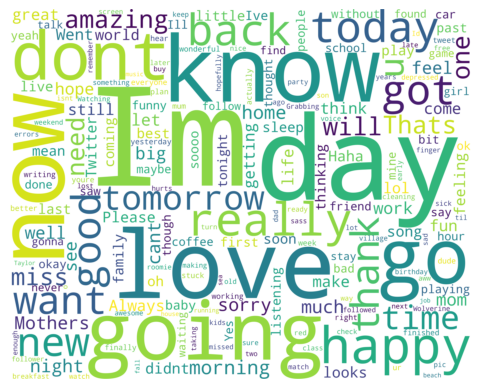

In [28]:
text = ' '.join(train['cleaned_description'])

cloud = WordCloud(collocations = False, background_color = 'white', width = 5000, height = 4000).generate(text)

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()